# 证券列表、板块和K线数据

欢迎来到大富翁量化教程第一章。在这一章里，我们将学习如何获取市场证券列表，如何获取某一支证券的K线数据，以及获取概念板块。

我们选择从这些功能开始这部教程是有原因的。如果你想要制定一个覆盖全市场的交易策略，你就需要知道如何获取所有的证券列表，并且一一获取它们的k线数据，进行运算，并发出交易信号。此外，如果你觉得最近有值得关注的概念板块，你也可能只想关注这些概念板块里的证券品种。

In [12]:
from IPython.display import clear_output
from omicron.core.types import FrameType
from omicron.core.timeframe import tf
import cfg4py
from omega.config import get_config_dir

cfg4py.init(get_config_dir())
import omicron
await omicron.init()
clear_output()

首先，这段代码引入了omicron这个核心库。Omicron主要负责数据的持久化、读数据，以及基础量化因子的计算。同时，还提供了大富翁中的一些核心类型的定义，比如帧类型(FrameType)，时间帧的相关计算(timeframe)等等。

这里还出现了[cfg4py](https://pypi.org/project/cfg4py/)。Cfg4Py是一个非常好用的配置管理工具，提供了配置热更新、代码提示和自动完成、环境变量替换、多部署环境自适应、层级式配置管理(cascading)、配置模版等功能。

Zillionare使用了Cfg4Py来管理配置。上面的第6行中，我们先对配置模块进行初始化。这让Omicron可以知道数据库和缓存的连接信息。关于这部分是如何工作的，请参见[TODO://diveintozillionare/configure](404.md)。如果您是使用我们提供的docker运行环境，那么您完全不用在意这些配置信息。只需要知道要使用Omicron，必须先进行配置初始化就可以了。

然后我们通过`omicron.init()`来对omicron进行初始化。初始化完成以后，证券列表就加载到程序中，数据库、缓存的连接也就都建立好了。现在，让我们看看都有哪些证券品种。

In [13]:
import pandas as pd
secs = await omicron.models.securities.get_security_list()
pd.DataFrame(data=secs[:5])

2021-03-25 22:38:12,024 E 13911 omicron.client.quotes_fetcher:_quotes_server_get:29 | Cannot connect to host localhost:3181 ssl:default [Connect call failed ('::1', 3181, 0, 0)]
Traceback (most recent call last):
  File "/home/userroot/miniconda3/envs/zillionare/lib/python3.8/site-packages/aiohttp/connector.py", line 969, in _wrap_create_connection
    return await self._loop.create_connection(*args, **kwargs)  # type: ignore  # noqa
  File "/home/userroot/miniconda3/envs/zillionare/lib/python3.8/asyncio/base_events.py", line 1025, in create_connection
    raise exceptions[0]
  File "/home/userroot/miniconda3/envs/zillionare/lib/python3.8/asyncio/base_events.py", line 1010, in create_connection
    sock = await self._connect_sock(
  File "/home/userroot/miniconda3/envs/zillionare/lib/python3.8/asyncio/base_events.py", line 924, in _connect_sock
    await self.sock_connect(sock, address)
  File "/home/userroot/miniconda3/envs/zillionare/lib/python3.8/asyncio/selector_events.py", line 49

TypeError: 'NoneType' object is not subscriptable

返回值包括证券代码（如000001.XSHG）,证券名称（如平安银行，上证指数等），证券简码(如PAYX)，该证券的上市交易日，终止上市时间，以及证券类型。

最后一栏是证券类型。大富翁支持的证券类型主要有股票(stock)，指数(index),对于ETF基金(etf),此外还有分级(fja,fjb,fjm），场内交易货币基金和其它基金。目前大富翁只接入了聚宽一家数据源，聚宽是支持这些类型的，所以大富翁当下也因此支持这些类型定义。不过，这部分定义未来可能会有所更改。但是，对于`stock`和`index`的定义，会一直保持不变。

这里提示一下关于上市交易日和终止上市时间的使用。在做短线交易时，我们并不需要获取那些已退市证券的数据，这时就要使用终止上市时间来进行过滤。有时候为了获取足够长的数据来进行演算，我们也需要使用上市交易日来过滤掉一些刚上市不久、数据还不够充分的数据。

证券代码在不同的行情软件中，表示方法并不一致。上交所和深交所原始数据中，并没有上述代码中的".XSHG"这样的后缀，因此，000001这样的代码在不同的市场上可能都存在，只是含义不同。比如000001在上交所这边代表上证指数，而在深交所则代表平安银行。如果你拿到的是这样的数据，则需要先进行转码处理。在大富翁的数据中，我们使用了带交易所编号的全码，这样处理是比较恰当的。每个证交所都会保证自己的编码系统的惟一性，因此这个全码就惟一标识了一支证券品种。

上面的代码中引入了pandas这个库。这里并不是必须的，我们在这里引用它，只是因为通过它可以使得输出更整洁美观一点。`omicron.models.securities.get_security_list()`返回的数据类型是numpy数组。在zillionare中，更广泛使用的数据结构是numpy的structured array，与dataframe相比，它在易用性、性能和内存占用上，都更加有优势。当然，这个对比仅限于行情数据处理这个场景。在其它场景下，也可能dataframe更有优势。

我们常常通过Securities这个类来操作证券列表，而不直接使用上面的接口返回的数据。

In [ ]:
from omicron.models.securities import Securities

secs = Securities()
secs.choose(['index'])[:3]

通过上面的代码，我们从全市场中选择了指数型标的。

现在，让我们来看看如何获得这些标的更多的信息。

In [15]:
from omicron.models.security import Security

sec = Security('000001.XSHE')
print(sec.code, sec.display_name, sec.ipo_date, sec.end_date, sec.name)

000001.XSHE 平安银行 1991-04-03 2200-01-01 PAYH


如果我们需要判断一支证券标的是否为次新股，那么可以通过`sec.days_since_ipo`来得到其信息：

In [ ]:
sec.days_since_ipo()

Security类包含了证券的最基本的信息，比如代码、名字、上市日期等。

但每支证券（股票）还会有自己的行业属性、地域属性（总部或者注册地），此外还有概念（题材）等属性。除此之外，象通达信软件，还会给每支股票打上风格属性，比如"新股"、"近期强势"、"超跌"等。

在A股，市场炒作气氛浓郁时，会发生炒地图（比如自贸区、成渝规划）、炒概念（比如2020年的免税、地摊）、炒行业（2020年下半年的光伏既是概念、也是行业。光伏景气是一个行业全产业链的景气）。对短线炒题材的选手来说，如何蹭到具有多个概念的股票，是很重要的选股策略。

大富翁在1.0中并未提供这些概念分类，因为我们的目标是为量化交易提供高性能的计算平台，而不是简单重复其它工具都有的功能。但是，由于大富翁集成了jqdatasdk,jqdatasdk的这些功能，对您来说也是完全开箱即用的。

这里我们以如何找出同时具有多个概念的个股为例，来讲解聚宽相关的API。

假设我们要获取具有"智能电网"、"物联网”概念属性的深圳本地股：

In [3]:
# 获取地域。这里要使用finance中的查询
import os
import jqdatasdk as jq

account = os.environ['JQ_ACCOUNT']
password = os.environ['JQ_PASSWORD']
jq.auth(account, password)

提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改
auth success 


首先我们要引入jqdatasdk并且登录进去。我们这里使用的方法是，通过环境变量设置您的聚宽账号和密码，然后通过`os.environ`来获取它们。这是一种出于安全考虑的技巧：即使您分享了您的策略，也不会意外泄露您的账号和密码。

In [7]:
from jqdatasdk import finance
from jqdatasdk import query

# 通过jqdatasdk获取证券列表
securities = jq.get_all_securities()
code = '000001.XSHE'
rec = finance.run_query(query(finance.STK_COMPANY_INFO).filter(finance.STK_COMPANY_INFO.code==code).limit(1))

#我们使用下面的函数，将前面获得的securities对象加上两列，即province和city
def add_region_info(securities):
    company_infos = finance.run_query(query(finance.STK_COMPANY_INFO))
    for code in securities.index:
        rec = company_infos[company_infos['code'] == code]
        if len(rec) == 0:
            securities.loc[code, 'province'] = None
            securities.loc[code, 'city'] = None
        else:
            securities.loc[code, 'province'] = rec['province'].iat[0]
            securities.loc[code, 'city'] = rec['city'].iat[0]
add_region_info(securities)
securities[:3]

display_name  name start_date   end_date   type province city
000001.XSHE         平安银行  PAYH 1991-04-03 2200-01-01  stock       广东  深圳市
000002.XSHE          万科A   WKA 1991-01-29 2200-01-01  stock       广东  深圳市
000004.XSHE         国华网安  GHWA 1990-12-01 2200-01-01  stock       广东  深圳市

可以看到，与前面的输出信息相比，这里的输出多了公司所在地省市的信息。下面我们看看如何获取概念板块：

In [10]:
# 获取概念板块
concepts = jq.get_concepts()

def query_stock_by_concept(query_concepts, province=None, city=None):
    stocks = set()
    for name in query_concepts:
        concept = concepts[concepts['name'] == name]
        if len(concept) == 0:
            continue
            
        idx = concept.index[0]
        members = set(jq.get_concept_stocks(idx))
        if len(stocks) == 0:
            stocks = members
        else:
            stocks = stocks.intersection(members)
         
    results = []

    for code in stocks:
        if province and securities.loc[code, 'province'] != province:
            continue
        if city and securities.loc[code, 'city'] != city:
            continue
            
        results.append(code)
        
    return results
        
#jq.get_concept_stocks('GN001')
stocks = query_stock_by_concept(['智能电网','物联网'],'广东','深圳市')
print(stocks)

['300044.XSHE', '300514.XSHE']


经过查询，我们得到两只股票，300044.XSHE和300514.XSHE。如果我们通过这两个代码来构造Security对象，就可以得到它们的名字：

In [16]:
print(Security('300044.XSHE').display_name)

赛为智能


好了！受相关限制，一些知名的大V是不会在头条或者微博里晒他们选的股的，但会提示相关概念。现在，你是不是能跟上他们的步子了呢？

接下来，让我们看看如何获取行情数据：

In [18]:
import datetime

sec = Security("000001.XSHE")
start = datetime.date(2020, 12, 1)
end = datetime.date(2020, 12, 11)
await sec.load_bars(start, end, FrameType.DAY)

array([(datetime.date(2020, 12, 1), 19.7 , 20.51, 19.4 , 20.05, 1.26371975e+08, 2.51601078e+09, 120.77),
       (datetime.date(2020, 12, 2), 19.93, 20.06, 19.52, 19.63, 8.89385290e+07, 1.75863919e+09, 120.77),
       (datetime.date(2020, 12, 3), 19.78, 19.86, 19.17, 19.54, 7.14452300e+07, 1.39308502e+09, 120.77),
       (datetime.date(2020, 12, 4), 19.47, 19.47, 18.97, 19.3 , 8.91347840e+07, 1.70763907e+09, 120.77),
       (datetime.date(2020, 12, 7), 19.31, 19.39, 18.68, 18.91, 8.73806610e+07, 1.65517347e+09, 120.77),
       (datetime.date(2020, 12, 8), 18.92, 19.03, 18.53, 18.71, 7.19647510e+07, 1.34595173e+09, 120.77),
       (datetime.date(2020, 12, 9), 18.79, 19.05, 18.68, 18.71, 6.77221150e+07, 1.27748444e+09, 120.77),
       (datetime.date(2020, 12, 10), 18.73, 18.88, 18.45, 18.65, 6.07866550e+07, 1.13091625e+09, 120.77),
       (datetime.date(2020, 12, 11), 18.71, 18.8 , 18.22, 18.52, 8.87793870e+07, 1.64239231e+09, 120.77)],
      dtype=[('frame', 'O'), ('open', '<f4'), ('high

注意到很多函数都是异步的。这里加载的行情数据，关于量能方面，是通过volume和amount来表示的，分别对应着成交量（手数）和成交额（金额，单位元）。很多时候我们更希望使用换手率的概念，特别是当我们需要在各个品种之间横向比较的时候。

要获取换手率，需要给`load_bars`传入`turnover`参数：

In [19]:
await sec.load_bars(start, end, FrameType.DAY, turnover=True)

2021-03-25 23:01:19,505 I 13911 gino.engine._SAEngine:_execute_context:1234 | SELECT valuation.frame, valuation.circulating_cap 
FROM valuation 
WHERE valuation.code IN ($1) AND valuation.frame <= $2 ORDER BY valuation.frame DESC 
 LIMIT $3
2021-03-25 23:01:19,507 I 13911 gino.engine._SAEngine:_execute_context:1236 | ('000001.XSHE', datetime.date(2020, 12, 11), 9)


rec.array([(datetime.date(2020, 12, 1), 19.7 , 20.51, 19.4 , 20.05, 1.26371975e+08, 2.51601078e+09, 120.77, 0.6512088 ),
           (datetime.date(2020, 12, 2), 19.93, 20.06, 19.52, 19.63, 8.89385290e+07, 1.75863919e+09, 120.77, 0.45831013),
           (datetime.date(2020, 12, 3), 19.78, 19.86, 19.17, 19.54, 7.14452300e+07, 1.39308502e+09, 120.77, 0.36816522),
           (datetime.date(2020, 12, 4), 19.47, 19.47, 18.97, 19.3 , 8.91347840e+07, 1.70763907e+09, 120.77, 0.45932144),
           (datetime.date(2020, 12, 7), 19.31, 19.39, 18.68, 18.91, 8.73806610e+07, 1.65517347e+09, 120.77, 0.45028225),
           (datetime.date(2020, 12, 8), 18.92, 19.03, 18.53, 18.71, 7.19647510e+07, 1.34595173e+09, 120.77, 0.37084237),
           (datetime.date(2020, 12, 9), 18.79, 19.05, 18.68, 18.71, 6.77221150e+07, 1.27748444e+09, 120.77, 0.3489796 ),
           (datetime.date(2020, 12, 10), 18.73, 18.88, 18.45, 18.65, 6.07866550e+07, 1.13091625e+09, 120.77, 0.31324038),
           (datetime.date(2020,

现在，让我们用get_bars来做一点实际的工作。我们来画一条平吉林森工今天（2020年10月13日）的分时线。

注意分时线的均线有两种算法。我们对个股是用截止当前的成交额（使用numpy的cumsum函数），除以截止当前的成交量来求得的。它对波动起到有效地平滑作用，而且成交量越小的价格，在最终均价中占的权重也越小，从而滤掉了做骗线的杂波。对于指数，上述方法似乎不对，可能跟指数编制方法有关，所以这里使用的是截止当前时刻的指数平均。

In [ ]:
import arrow # arrow是一个时间处理库
end = arrow.get('2020-10-13 15:00:00', tzinfo='Asia/Shanghai')
start = tf.shift(end, -240, FrameType.MIN1)

bars_jlsg = await Security('600189.XSHG').load_bars(start, end, FrameType.MIN1)
bars_sh = await Security('000001.XSHG').load_bars(start, end, FrameType.MIN1)

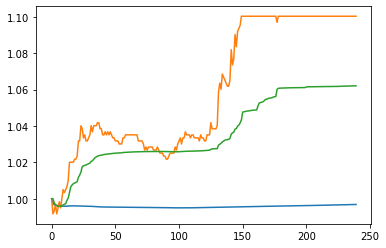

In [25]:
import matplotlib.pyplot as plt # matplotlib是常用的绘图库
import numpy as np

# 大盘走势,为便于比较，使用了涨跌幅

plt.plot((np.cumsum(bars_sh['close'])/np.cumsum(bars_sh['close']>0))/bars_sh['close'][0])
# 吉林森工的股价变化
plt.plot(bars['close']/bars['close'][0])
# 吉林森工的均价线
plt.plot((np.cumsum(bars['money'])/np.cumsum(bars['volume']))/bars['close'][0])

上图中，黄色的线是个股的收盘分时线，绿色线是其均价线，蓝色线是大盘均价线。

从图中可以看出，一开盘在大盘下探时，吉林森工股价就快速上涨，此后随大盘微跌，但均价线支撑有力。在午后确认大盘企稳后，主力快速拉升到涨停。

这就是教程的第一个策略：通过分时线与大盘走势对比，来确定个股的强弱。是否有效，还请大家验证。要完全量化这一策略，还需要检测波峰波谷，然后进行个股与大盘的对比。

In [12]:
from omicron.core.timeframe import tf

print(f"{tf.day_frames[0]}~{tf.day_frames[-1]}")

print(f"{tf.week_frames[0]}~{tf.week_frames[-1]}")

print(f"{tf.month_frames[0]}~{tf.month_frames[-1]}")


20050104~20230209
20050107~20230209
20050131~20230209


在上面的API中，我们定义了行情数据的起始和结束区间。但是，在量化交易中，我们常常需要知道某个区间包含多少条数据记录。比如，当我们要计算2020年12月5日这一天，某支股票的季线、月线和10日线时，更方便的使用方法是指定结束日期，和要获取的记录条数。至于这段时间的起点是哪一天，我们并不特别关心。

由于存在节假日休市的情况，在上述场景下，要正确地计算出起始日期就更困难了。因此，Omicron提供了一个`timeframe`模块，来帮助做时间帧方面的计算。

timeframe模块以数组的形式，提供了所有的交易日、周线收盘日和月线收盘日。

可以看出，大富翁提供的日线帧从2005年1月4日开始，到2023年2月9日结束。不过，对于还没有到来的日子，具体某一天是交易日还是休市日，都还不确定，这个数据我们会实时更新的。

周线和月线帧的最后结束日并没有对齐，当然由于这一天还非常遥远，所以这里的数据也没有对错之分。

在大富翁里，你会经常看到时间帧的概念。因为对交易数据来说，数据总是在固定的时间点进行汇总，所以不应该使用普通意义上的时间概念。比如2019年1月4日的10时35分，对于1分钟线和5分钟线是有意义的，对于其它周期则是意义的。我们把这个时间点称作5分钟（或者1分钟）的一个时间帧。

timeframe模块提供了以下主要功能:

- int2time/time2int/date2int/int2date
  
    在进程间及不同的模块间传递时间数据时常常容易发生问题，比如，你无法直接往redis缓存里存入时间数据。所以，大富翁使用整数来存储日期/时间。比如，20050104代表2005年1月4日，200501041030代表2005年1月4日10时30分钟。使用这种表示，比较节省内存，同时时间之间仍然可以比较，并没有改变它们之间的次序。
    
- shift函数及衍生的各种*_shift函数

    给定一个时间，比如2019年1月4日，如果我们需要知道4个交易日前的那一天是哪一天，这时候就需要使用shift/day_shift函数。
    
- count_*_frames 计算两个时间帧之间共有多少个时间帧。
- is_trade_day 判断某天是否是交易日
- is_open_time 判断某个时间点是否处于开盘期间
- is_opening_call_auction_time 判断某个时间点是否属于早盘集合竞价时段
- is_closing_call_auction_time 判断某个时间点是否属于尾盘集合竞价时段
- floor 根据frame_type,将给定的时间对齐到最接近的上一个frame
- ceiling 对应于floor
- frame_len 对给定的分钟级别线，求一个交易日包含多少个周期
- first_frame 不同的周期，每天开盘的第一个时间帧是不一样的。比如对分钟线，第一个时间帧是9:31，对5分钟线则是9:35分。这个函数用于获得指定日期的对应周期的第一帧
- get_frames 获取给定的起始时间和结束时间间，指定的周期对应的时间帧
- get_frames_by_count，类似于get_frames，但参数不一样
- combine_time 将指定的日期与时间结合成一个新的datetime

这些功能非常基础，也十分重要。当您开始获取数据、编写策略时，会越来越依赖于它们。

Aha! jq提供的交易数据都是起始于2005年1月4日的。因此，如果你要追忆老八股当年的盛况，还得使用其它数据源。不过，对我们短线量化而言，这个数据已足够充分了。实际上，过久的历史数据如果不能正确使用，反倒会让你得出错误结论。比如，一些股票退市了，会导致幸存者偏差（幸运的是，为了不让你们出这种错误，村里很少让股票退市！）；这期间发生的重大的制度改革（比如股权分置改革就是从2005年起的），则会对某些分析方法产生影响。当然，对于短线而言，我们只关心股价，我们认为一切因素都反映在股价里。所以只要股本变动、除权除息这些事都已正确记录的话，几乎仅凭行情数据本身，我们仍然可以分析出正确结论。

对于前面的问题，要获取去年1月1日到今年1月1日之间的数据，比如上证指，我们可以这样操作

In [ ]:
days = jq.get_trade_days('2019-1-1', '2020-1-1')
print(f"起始时间:{days[0]}, 结束时间{days[-1]}, 总共{len(days)}个交易日")
bars = jq.get_bars('000001.XSHG', len(days), unit='1d', end_dt='2020-1-1')
print(bars[:3])
print(bars[-3:])

一般我们按250天算年线，不过对于2019年来讲，这一年只有244个交易日。尽管指定的时间范围是2019年1月1日到2020年1月1日，但我们获得的上证指数，从2019年1月2日起，到2019年12月31日止。因为交易日历告诉我们，2019年的第一个交易日，是1月2日。

这里引出了我们在上一篇文章中已经见到的一个API，get_bars，其定义如下：

In [ ]:
get_bars(security, count, unit='1d',
      fields=['date','open','high','low','close'],
         include_now=False, end_dt=None, fq_ref_date=None,df=True)

一般情况下，建议改写fields。fields接受的完整列表包括： 'date', 'open','high','low','close','volume','money','open_intereset','factor'。返回结果中，volume为成交量，以手数（100股为一手）为单位，money为成交额。

默认情况下，这个API返回的数据是不复权的，如果要返回复权数据，则需要通过fq_ref_date来指定复权日期，这样返回的数据，都会复权到指定日期那一天为止。如果你需要将数据缓存起来，建议始终取未复权的数据，然后在使用数据时，通过复权因子来计算。如果你将未复权数据与复权数据混用在一起，可想而知，最终结果会是错的。在不同时间，分段取得的复权数据，也是不能混用的。比如，你已经有了截止上一周的某个股票的复权数据，现在只取本周的增量数据，但指定复权到当天，这样两组数据也是不能混用的。

这个API返回的数据格式有两种，一种是pandas的DataFrame,另一种是numpy的structured array。推荐使用structured array，因为这种数据结构无论是计算效率，还是内存效率都要远高于DataFrame(接近一倍左右）。另外，我更喜欢numpy的structured array的index方式，比如：

In [ ]:
# 对numpy structured array结构，以下引用是合法的
bars[-1]['close']
# 或者
bars['close'][-1]
# 对Dataframe结构，你应该始终使用这样的方式来引用最后一天的收盘价
bars['close'].iat[-1]
# 显然，numpy的方式更简洁

JQ的这个API有一些难以理解的地方，主要体现在include_now这个参数上。如果现在的时间是2020年10月13日下午16时，由于A股已经收盘，因此当天的上证指数已经锁定。但你这样调用get_bars，却得不到这一天的数据，这是我们需要加以小心的地方：

In [ ]:
# 这样只会返回到10-12的数据
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt='2020-10-13')
print(bars)

# 这样也只返回到10-12的数据
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt='2020-10-13',include_now=True)
print(bars)

# 这样则会返回到10-13的数据，但如果是盘中调用，则是调用当时的数据，当然，似乎也只能这样
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt=None, include_now=True)
print(bars)

# 如果在盘后这样调用，也能返回10-13日的数据，但在盘中这样调用，返回的数据却是调用当时的数据
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt='2020-10-13 16:00:00', include_now=True)
print(bars)

**声明：本教程中引用到的股票代码，仅为演示如何使用相关API之目的，并非推荐。**